In [1]:
from skimage import measure, io, morphology, transform
import tifffile
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import tqdm
import pandas as pd
import numpy as np
import glob
from calc_lifetimes import calculate_lifetimes
from sklearn import decomposition
from analysis import calculate_DGI
from scipy import spatial
import pickle
from analysis import calculate_DGI
import itertools

import matplotlib as mpl
from cycler import cycler

%matplotlib inline

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
def calculate_dendritic_area(path_to_data, spacing=(0.4,0.076,0.076), step_size=2, max_timepoints=100):
    
    """
    This function takes in the file path to a folder containing all of the masks of the neurons.
    It then calculates the surface area of every neuron using a marching cubes algorithm from scikit-image.
    The surface area of the mesh will then be computed. 

    This function computes the surface area of the whole neuron and of the stable pixels only.
    Both will then be saved in a dataframe where the timepoints are in the rows.

    Parameters:

    path_to_data: Path to the folder containing the masks of all the neurons to use.
    save_path: Path to the folder where the dataframe should be saved.
    filename: name of the output files
    spacing: Voxel sizes used in the calculation of the mesh in the marching cubes algorithm.
    step_size: Distance of neighbours to use for the calculation of the mesh.
    max_timepoints: maximum number of timepoints imaged in all of the sessions.
    
    Output:
    surfaces: Dataframe containing the surface area of the whole dendrite.
    surfaces_stable: Dataframe containing the surface area of the stable pixels.
    """
    
    file_list = sorted(glob.glob(path_to_data + '*.tif'))
    
    surfaces = np.zeros((max_timepoints,len(file_list)))
    
    for index, file in enumerate(file_list):
        mask = tifffile.imread(file)
        areas = np.zeros((mask.shape[0]))
        for i  in tqdm.tqdm(range(0,mask.shape[0])):
            if mask[i].sum() == 0:
                areas[i] = 0
            else:
                verts, faces, normals, values = measure.marching_cubes(mask[i], step_size=2, spacing=(0.4,0.076,0.076))
                areas[i] = measure.mesh_surface_area(verts, faces)
        surfaces[0:len(areas), index] = areas
        
    surfaces = pd.DataFrame(surfaces)
    
    surfaces_stable = np.zeros((max_timepoints,len(file_list)))

    for index, file in enumerate(file_list):
        mask = tifffile.imread(file)
        mask = calculate_lifetimes(mask)
        
        mask = np.int16(mask > 3)
        
        areas = np.zeros((mask.shape[0]))
        for i  in tqdm.tqdm(range(3,mask.shape[0])):
            ## to make sure that there are no 0 values since the marching cubes algorithm cannot deal with them
            if mask[i].sum() == 0: 
                areas[i] = 0
                
            else:
                verts, faces, normals, values = measure.marching_cubes(mask[i], step_size=2, spacing=(0.4,0.076,0.076))
                areas[i] = measure.mesh_surface_area(verts, faces)
        surfaces_stable[0:len(areas), index] = areas
        
    surfaces_stable = pd.DataFrame(surfaces_stable)
    
    ## To not include the zero values in the datafram in the mean/std calculation
    surfaces = surfaces.replace(0, np.NaN) 
    surfaces_stable = surfaces_stable.replace(0, np.NaN)
    
    surfaces['mean_surface'] = surfaces.iloc[:,:len(file_list)].mean(axis=1)
    surfaces['surface_std'] = surfaces.iloc[:,:len(file_list)].std(axis=1)
    
    surfaces_stable['mean_surface'] = surfaces_stable.iloc[:,:len(file_list)].mean(axis=1)
    surfaces_stable['surface_std'] = surfaces_stable.iloc[:,:len(file_list)].std(axis=1)
    
    
    
    return surfaces, surfaces_stable
        

In [3]:
def calculate_dendritic_volume(path_to_data, lifetime=5, max_timepoints=100):

    """
    This function calculates the volume of a dendrite over time based on the number of pixels that are in the 3D stack.
    
    Parameters:
    path_to_data: path to the masks of neurons
    max_timepoints: maximum number of timepoints imaged in all of the sessions.
    
    Returns:
    
    volumes: volumes of all the timepoints over time
    """
    file_list = sorted(glob.glob(path_to_data + '*.tif'))
    
    volumes = np.zeros((max_timepoints,len(file_list)))
    volumes_stable = np.zeros((max_timepoints,len(file_list)))
    
    for index, file in enumerate(file_list):
        neuron = tifffile.imread(file)
        neuron_lifetimes = calculate_lifetimes(neuron)
        
        neuron_volumes = np.zeros((neuron.shape[0]))
        neuron_life_volumes = np.zeros((neuron.shape[0]))
        for stack in tqdm.tqdm(range(0,neuron.shape[0])):
            volume = np.sum(neuron[stack] > 0)
            stable_volume = np.sum(neuron_lifetimes[stack] > lifetime-1)
            neuron_volumes[stack] = volume
            neuron_life_volumes[stack]= stable_volume
        volumes[:neuron.shape[0], index] = neuron_volumes
        volumes_stable[:neuron_lifetimes.shape[0], index] = neuron_life_volumes
    
    volumes = pd.DataFrame(volumes)
    volumes_stable = pd.DataFrame(volumes_stable)
    ## To not include the zero values in the datafram in the mean/std calculation
    volumes = volumes.replace(0, np.NaN)
    volumes_stable = volumes_stable.replace(0, np.NaN)

    volumes['mean_volume'] = volumes.iloc[:,:len(file_list)].mean(axis=1)
    volumes['volume_std'] = volumes.iloc[:,:len(file_list)].std(axis=1)
    
    volumes_stable['mean_volume'] = volumes_stable.iloc[:,:len(file_list)].mean(axis=1)
    volumes_stable['volume_std'] = volumes_stable.iloc[:,:len(file_list)].std(axis=1)
        
    return volumes, volumes_stable
    

In [4]:
path_to_data_a = '/Users/hoermann/Desktop/TLI_project/Analysis/Neurons/SubtypeA/masks/'
path_to_data_c = '/Users/hoermann/Desktop/TLI_project/Analysis/Neurons/SubtypeC/masks/'

In [5]:
entry_points_a = np.array([
    [40,238,235],
    [21,192,271],
    [42,225,175],
    [46,320,256],
    [20,212,271],
    [25,255,238],
    [24,293,236]
])

In [6]:
entry_points_c = np.array([
    [28,222,228],
    [22,120,247],
    [26,272,161],
    [23,201,213],
    [29,270,194],
    [38,193,173],
    [28,241,234]   
])

In [7]:
entry_points_d = np.array([
    [24,326,123],
    [21,216,234]
])

In [24]:
surfaces_a, surfaces_stable_a = calculate_dendritic_area(path_to_data_a)
surfaces_c, surfaces_stable_c = calculate_dendritic_area(path_to_data_c)

100%|████████████████████████████████████████████████████████████████████████████████████| 89/89 [00:02<00:00, 30.30it/s]
<tifffile.TiffPage 0 @8> imagej_metadata failed with ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
100%|████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:02<00:00, 31.48it/s]
<tifffile.TiffPage 0 @8> imagej_metadata failed with ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
100%|████████████████████████████████████████████████████████████████████████████████████| 85/85 [00:02<00:00, 30.67it/s]


In [25]:
volumes_a, volumes_stable_a = calculate_dendritic_volume(path_to_data_a)
volumes_c, volumes_stable_c = calculate_dendritic_volume(path_to_data_c)

100%|████████████████████████████████████████████████████████████████████████████████████| 89/89 [00:01<00:00, 67.23it/s]
<tifffile.TiffPage 0 @8> imagej_metadata failed with ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
100%|████████████████████████████████████████████████████████████████████████████████████| 88/88 [00:01<00:00, 59.75it/s]


/var/folders/m7/96sw_tzd4rg0_kj51gyp_px8hx4v7j/T/ipykernel_69627/2733079740.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(list([36,40,44,48,52,56]))


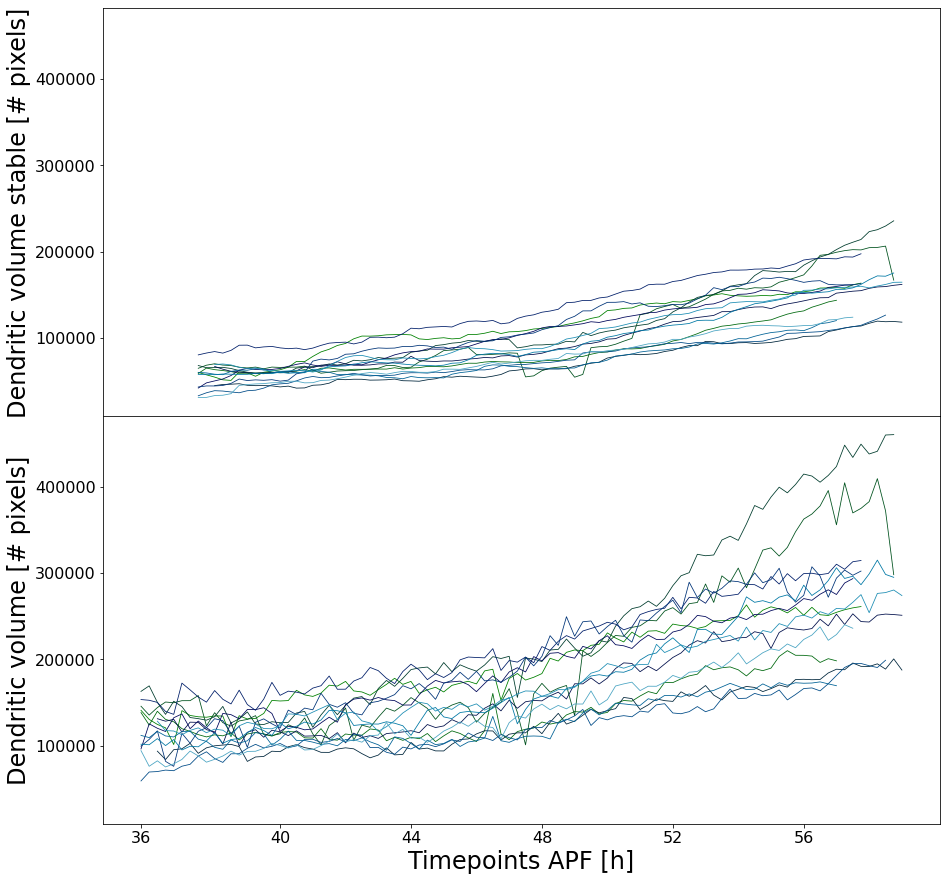

In [68]:
fig, ax = plt.subplots(2,1, figsize=(15,15), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0,wspace=0)

linewidth=0.8

for i in volumes_stable_a.columns.values[:-2]:
    ax[0].plot(volumes_stable_a.iloc[:,i], label=f'{i}', lw=linewidth)
    
    
for i in volumes_stable_c.columns.values[:-2]:
    ax[0].plot(volumes_stable_c.iloc[:,i], label=f'{i}', lw=linewidth)


for i in volumes_a.columns.values[:-2]:
    ax[1].plot(volumes_a.iloc[:,i], label=f'{i}', lw=linewidth)

    
for i in volumes_c.columns.values[:-2]:
    ax[1].plot(volumes_c.iloc[:,i], label=f'{i}', lw=linewidth)


ax[0].set_ylabel('Dendritic volume stable [# pixels]')
ax[1].set_ylabel('Dendritic volume [# pixels]')
ax[1].set_xticklabels(list([36,40,44,48,52,56]))
ax[1].set_xticks(list([0,17,33,49,65,81]))
ax[1].set_xlabel('Timepoints APF [h]')
plt.savefig('/Users/hoermann/Desktop/TLI_project/Analysis/Neurons/Volume_over_time.png', dpi=1000)

/var/folders/m7/96sw_tzd4rg0_kj51gyp_px8hx4v7j/T/ipykernel_69627/1819592013.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list([36,40,44,48,52,56]))


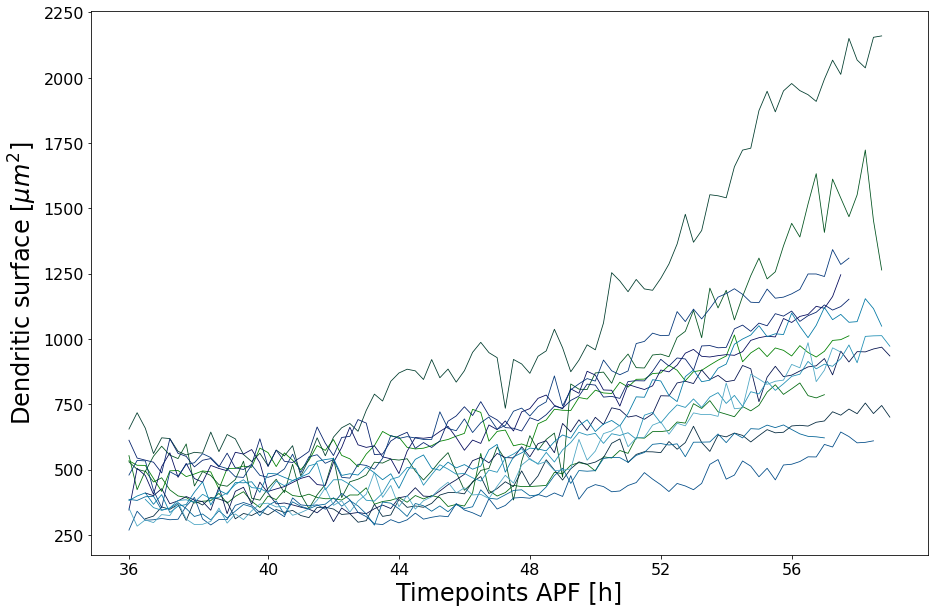

In [243]:
fig, ax = plt.subplots(1,1, figsize=(15,10), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0,wspace=0)

linewidth=0.8

# for i in surfaces_stable_a.columns.values[:-2]:
#     ax[0].plot(surfaces_stable_a.iloc[:,i], label=f'{i}', lw=linewidth)
    
    
# for i in surfaces_stable_c.columns.values[:-2]:
#     ax[0].plot(surfaces_stable_c.iloc[:,i], label=f'{i}', lw=linewidth)


for i in surfaces_a.columns.values[:-2]:
    ax.plot(surfaces_a.iloc[:,i], label=f'{i}', lw=linewidth)

    
for i in surfaces_c.columns.values[:-2]:
    ax.plot(surfaces_c.iloc[:,i], label=f'{i}', lw=linewidth)


# ax[0].set_ylabel('Dendritic surface stable [$µm^2$]')
ax.set_ylabel('Dendritic surface [$µm^2$]')
ax.set_xticklabels(list([36,40,44,48,52,56]))
ax.set_xticks(list([0,17,33,49,65,81]))
ax.set_xlabel('Timepoints APF [h]')
plt.savefig('/Users/hoermann/Desktop/TLI_project/Analysis/Neurons/Surface_over_time.png', dpi=1000)

In [67]:

mycmap = mpl.cm.get_cmap('ocean')
color_list = [mpl.colors.rgb2hex(mycmap(i)) for i in range(mycmap.N)]

mpl.rcParams['axes.prop_cycle'] = cycler(color=color_list[::15])
mpl.rcParams['axes.labelsize'] =24
mpl.rcParams['xtick.labelsize'] =16
mpl.rcParams['ytick.labelsize'] =16
mpl.rcParams['legend.fontsize'] =18



/var/folders/m7/96sw_tzd4rg0_kj51gyp_px8hx4v7j/T/ipykernel_69627/3278187592.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list([36,40,44,48,52,56]))


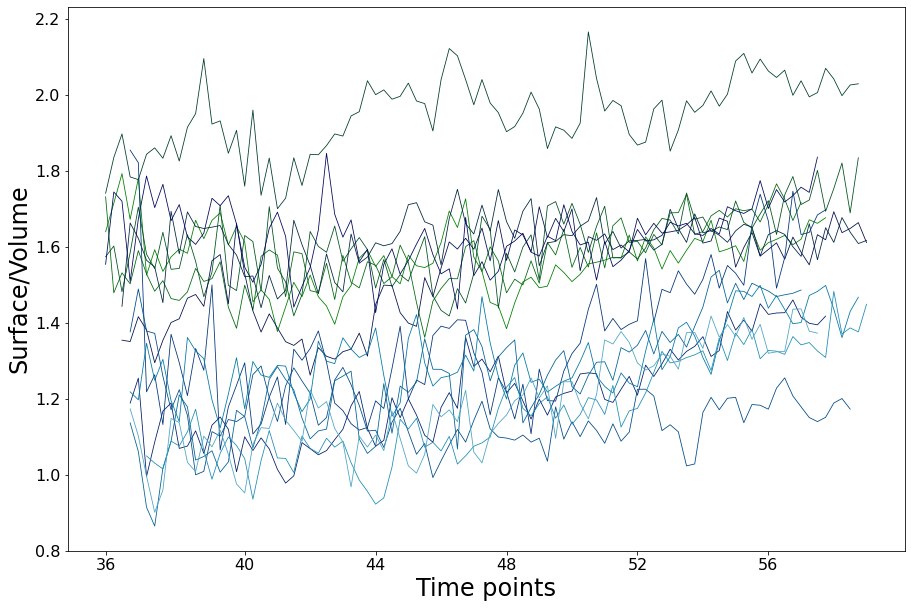

In [96]:
fig, ax = plt.subplots(1,1, figsize=(15,10), sharex=True)
fig.subplots_adjust(hspace=0,wspace=0)

linewidth=0.8

# for i in surfaces_stable_a.columns.values[:-2]:
#     ax[0].plot(surfaces_stable_a.iloc[:,i]/(volumes_stable_a.iloc[:,i]*0.4*0.076*0.076), label=f'{i}',
#                lw=linewidth)
    
# #ax[0,0].set_title('Surfaces/Volume stable A')

    
# for i in surfaces_stable_c.columns.values[:-2]:
#     ax[0].plot(surfaces_stable_c.iloc[:,i]/(volumes_stable_c.iloc[:,i]*0.4*0.076*0.076), label=f'{i}', 
#                lw=linewidth)
#ax[0,1].set_title('Surfaces/Volume stable C/D')

for i in surfaces_a.columns.values[:-2]:
    ax.plot(surfaces_a.iloc[:,i]/(volumes_a.iloc[:,i]*0.4*0.076*0.076), label=f'{i}a',
               lw=linewidth)

#ax[1,0].set_title('Surfaces/Volume A')

    
for i in surfaces_c.columns.values[:-2]:
    ax.plot(surfaces_stable_c.iloc[:,i]/(volumes_c.iloc[:,i]*0.4*0.076*0.076), label=f'{i}',
    lw=linewidth)
#ax[1,1].set_title('Surfaces/Volume C/D')

ax.set_ylabel("Surface/Volume stable")
ax.set_ylabel("Surface/Volume")
ax.set_xlabel("Time points")
ax.set_xticklabels(list([36,40,44,48,52,56]))
ax.set_xticks(list([0,17,33,49,65,81]))
plt.savefig('/Users/hoermann/Desktop/TLI_project/Analysis/Neurons/Surface_Volume_Ratio.png', dpi=1000)

In [8]:
def calculate_background_depth(path_to_data, list_of_entry_points, max_timepoints=100, save_path=None, binning=10):
    
    """
    This function loads the background channel of the 5D TLI file and calculates the z-position
    with the highest mean fluorescent intensity for a square with a side length of the 'binning' argument.
    It returns a 2D array with the index of the z-slice with the highest value for each neuron and timepoint.
    The the size of the input array should be evenly dividable by the binning argument.
    
    Parameters:
    path_to_neuron: path to the folder containing 5D data
    save_path: where to save the 2D array
    binning: side length in pixels for the square
    
    Returns:
    neuron_max_z_time: dataframe containing the maximum z value for each timepoint for each neuron 
    
    """
    
    file_list = sorted(glob.glob(path_to_data + '*.tif'))
    neuron_max_z_time = np.zeros((max_timepoints,len(file_list)))

    
    for index, file in tqdm.tqdm(enumerate(file_list)):
        neuron_bg = tifffile.imread(file)[:,:,0,:,:]
        
        entry_point = list_of_entry_points[index]

        neuron_max_z = np.zeros(neuron_bg.shape[1])
        for stack in range(0, neuron_bg.shape[0]):
            for plane in range(0, neuron_bg.shape[1]):
                neuron_max_z[plane]= transform.resize(transform.downscale_local_mean(neuron_bg[stack,plane], (binning, binning)),
                                                      (int(neuron_bg.shape[2]), int(neuron_bg.shape[3])),
                                                      order=0)[entry_point[1], entry_point[2]]
            neuron_max_z_time[stack, index] = np.argwhere(neuron_max_z == neuron_max_z.max())[0]
            
    neuron_max_z_time = pd.DataFrame(neuron_max_z_time)
    
    return neuron_max_z_time

In [ ]:
path_to_data_5D_a = '/Users/hoermann/Desktop/TLI_project/Analysis/Neurons/SubtypeA/5D/'
path_to_data_5D_c = '/Users/hoermann/Desktop/TLI_project/Analysis/Neurons/SubtypeC/5D/'

In [ ]:
z_max_A = calculate_background_depth(path_to_data_5D_a, entry_points_a)
z_max_C = calculate_background_depth(path_to_data_5D_c, entry_points_c)

In [ ]:

# def plot_colorMaps(cmap):

#     fig, ax = plt.subplots(figsize=(4,0.4))
#     col_map = plt.get_cmap(cmap)
#     mpl.colorbar.ColorbarBase(ax, cmap=col_map, orientation = 'horizontal')

#     plt.show()

# for cmap_id in plt.colormaps():
#     print(cmap_id)
#     plot_colorMaps(cmap_id)

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))

mycmap = mpl.cm.get_cmap('gist_earth_r')

color_list = [mpl.colors.rgb2hex(mycmap(i)) for i in range(mycmap.N)]


for i in range(0,7):
    ax.plot(z_max_A.iloc[:84,i], label=f'{i}',alpha=1,color=color_list[i*40],lw=1.2)
    ax.hlines(z_max_A.iloc[:84,i].mean(), 0, 84, color=color_list[i*40],lw=1.2,ls=(0, (5, 10)))

ax.invert_yaxis()
#plt.legend()
ax.set_xlabel("Time points")
ax.set_ylabel("Z depth A")
plt.savefig('/Users/hoermann/Desktop/entry_point_z_movement_A.png', dpi=1000)

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))

mycmap = mpl.cm.get_cmap('gist_earth_r')

color_list = [mpl.colors.rgb2hex(mycmap(i)) for i in range(mycmap.N)]


for i in range(0,7):
    ax.plot(z_max_C.iloc[:84,i], label=f'{i}',alpha=1,color=color_list[i*40],lw=1.2)
    ax.hlines(z_max_C.iloc[:84,i].mean(), 0, 84, color=color_list[i*40],lw=1.2,ls=(0, (5, 10)))

ax.invert_yaxis()
#plt.legend()
ax.set_xlabel("Time points")
ax.set_ylabel("Z depth subtype C")
plt.savefig('/Users/hoermann/Desktop/TLI_project/Analysis/Neurons/entry_point_z_movement_C.png', dpi=1000)

In [9]:
def calculate_angles_over_time(path_to_data, list_of_entry_points, bins=24, max_timepoints=100, lifetime=6):
    """
    This function takes in the path to the masked files and the entry points of the corresponding neurons.
    They need to be in the same order.
    It then calculates the angle of each pixel and bins them according to the number of bins (default is 24).
    It calculates the angles for newly stable and transient pixels.
    
    Parameters:
    path_to_data: folder containing all of the masked files
    list_of_entry_points: list of entry points which should be in the same order as the files (sorted in ascending order).
    bins: number of bins to but the angles into
    
    Return:
    df_transient_angles: mean distribution of angles of the transient pixels over time
    df_stable_angles: mean distribution of angles of the newly stable pixels over time
    """
    
    
    file_list = sorted(glob.glob(path_to_data + '*.tif'))

    
    trans_angles = np.zeros((len(file_list), max_timepoints, bins))
    stable_angles = np.zeros((len(file_list), max_timepoints, bins))
    new_angles = np.zeros((len(file_list), max_timepoints, bins))
        
    for index, file in tqdm.tqdm(enumerate(file_list)):

        neuron_raw = tifffile.imread(file)
        neuron_raw = calculate_lifetimes(neuron_raw)
        
        
        neuron = neuron_raw.copy()
        neuron[(neuron < lifetime) * (neuron > 0)] = 1
        neuron[neuron > lifetime-1] = 2
        neuron = np.int8(neuron)
        
        neuron_newly_stable = np.int8(neuron ==2)[1:] - np.int8(neuron ==2)[:-1]
        
        neuron_newly_stable[neuron_newly_stable < 0] = 0
        neuron_newly_stable[neuron_newly_stable > 0] = 1
        
        neuron_coord_trans = np.argwhere(neuron == 1)
        neuron_coord_stable = np.argwhere(neuron == 2)
        neuron_coord_new = np.argwhere(neuron_newly_stable == 1)

        neuron_coord_trans[:,1:] = neuron_coord_trans[:,1:] - list_of_entry_points[index]
        neuron_coord_stable[:,1:] = neuron_coord_stable[:,1:] - list_of_entry_points[index]
        neuron_coord_new[:,1:] = neuron_coord_new[:,1:] - list_of_entry_points[index]

        neuron_trans_angles = np.rad2deg(np.arctan2(neuron_coord_trans[:,2], neuron_coord_trans[:,3]))
        neuron_stable_angles = np.rad2deg(np.arctan2(neuron_coord_stable[:,2], neuron_coord_stable[:,3]))
        neuron_new_angles = np.rad2deg(np.arctan2(neuron_coord_new[:,2], neuron_coord_new[:,3]))


        for i in range(0,neuron.shape[0]):
            angles = np.histogram(neuron_trans_angles[neuron_coord_trans[:,0] == i],
                                  bins=np.array(range(-180,180 + int(360/bins),int(360/bins)))
                                 )
            trans_angles[index, i] = angles[0]


        for i in range(3,neuron.shape[0]):
            angles = np.histogram(neuron_stable_angles[neuron_coord_stable[:,0] == i],
                                  bins=np.array(range(-180,180 + int(360/bins),int(360/bins)))
                                 )
            stable_angles[index, i] = angles[0]
    
        for i in range(3,neuron.shape[0]):
            angles = np.histogram(neuron_new_angles[neuron_coord_new[:,0] == i],
                                  bins=np.array(range(-180,180 + int(360/bins),int(360/bins)))
                                 )
            new_angles[index, i] = angles[0]
            

    
    stable_angles[stable_angles==0] = np.NaN
    trans_angles[trans_angles==0] = np.NaN
    new_angles[new_angles==0] = np.NaN
    
    
    
    
    df_stable_angles = pd.DataFrame(np.nanmean(stable_angles, axis=0))
    df_stable_angles_std = pd.DataFrame(np.nanstd(stable_angles, axis=0))

    df_trans_angles = pd.DataFrame(np.nanmean(trans_angles, axis=0))
    df_trans_angles_std = pd.DataFrame(np.nanstd(trans_angles, axis=0))

    df_new_angles = pd.DataFrame(np.nanmean(new_angles, axis=0))
    df_new_angles_std = pd.DataFrame(np.nanstd(new_angles, axis=0))
    
    stable_sum = df_stable_angles.sum(axis=1)
    stable_std_sum = df_stable_angles_std.sum(axis=1)
    trans_sum = df_trans_angles.sum(axis=1)
    trans_std_sum = df_trans_angles_std.sum(axis=1)
    new_sum = df_new_angles.sum(axis=1)
    new_std_sum = df_new_angles_std.sum(axis=1)
    
    for i in range(0, bins):
        df_stable_angles.iloc[:,i] = df_stable_angles.iloc[:,i]/stable_sum
        df_stable_angles_std.iloc[:,i] = df_stable_angles_std.iloc[:,i]/stable_std_sum
        df_trans_angles.iloc[:,i] = df_trans_angles.iloc[:,i]/trans_sum
        df_trans_angles_std.iloc[:,i] = df_trans_angles_std.iloc[:,i]/trans_std_sum
        df_new_angles.iloc[:,i] = df_new_angles.iloc[:,i]/new_sum
        df_new_angles_std.iloc[:,i] = df_new_angles_std.iloc[:,i]/new_std_sum

    return df_stable_angles, df_stable_angles_std, df_trans_angles, df_trans_angles_std, df_new_angles, df_new_angles_std
        

In [ ]:
stable_a, stable_a_std, transient_a, transient_a_std, new_a, new_a_std = calculate_angles_over_time(path_to_data_a, entry_points)

In [ ]:
stable_c,  stable_std_c, transient_c, transient_std_c, new_c, new_std_c = calculate_angles_over_time(path_to_data_c, entry_points_c)

In [16]:
def calculate_angles_over_time_centroid(path_to_data, bins=24, max_timepoints=100, lifetime=5):
    """
    This function takes in the path to the masked files of the corresponding neurons.
    It calculates the centroid of the 2D image and uses it as a reference for the whole neuron
    It then calculates the angle of each pixel and bins them according to the number of bins (default is 24).
    It calculates the angles for newly stable and transient pixels.
    
    Parameters:
    path_to_data: folder containing all of the masked files
    list_of_entry_points: list of entry points which should be in the same order as the files (sorted in ascending order).
    bins: number of bins to but the angles into
    
    Return:
    df_transient_angles: mean distribution of angles of the transient pixels over time
    df_stable_angles: mean distribution of angles of the newly stable pixels over time
    """
    
    
    file_list = sorted(glob.glob(path_to_data + '*.tif'))

    
    trans_angles = np.zeros((len(file_list), max_timepoints, bins))
    stable_angles = np.zeros((len(file_list), max_timepoints, bins))
    new_angles = np.zeros((len(file_list), max_timepoints, bins))
        
    for index, file in tqdm.tqdm(enumerate(file_list)):

        neuron_raw = tifffile.imread(file)
        neuron_raw = calculate_lifetimes(neuron_raw)
        
        neuron_z_project = np.int8(neuron_raw.sum(axis=1)>0)
        
        neuron_metrics = np.zeros((neuron_z_project.shape[0], 2))
        for i in range(0, neuron_z_project.shape[0]):
            if neuron_z_project[i].sum() == 0:
                neuron_metrics[i] = [0,0]
            else:
                neuron_metrics[i] = measure.regionprops(neuron_z_project[i])[0].centroid
        
        neuron = neuron_raw.copy()
        neuron[(neuron < lifetime) * (neuron > 0)] = 1
        neuron[neuron > lifetime-1] = 2
        neuron = np.int8(neuron)
        
        neuron_newly_stable = np.int8(neuron ==2)[1:] - np.int8(neuron ==2)[:-1]
        
        neuron_newly_stable[neuron_newly_stable < 0] = 0
        neuron_newly_stable[neuron_newly_stable > 0] = 1
        
        neuron_coord_trans = np.argwhere(neuron == 1)
        neuron_coord_stable = np.argwhere(neuron == 2)
        neuron_coord_new = np.argwhere(neuron_newly_stable == 1)
        
        map_trans = [neuron_coord_trans[:,0] == 0]
        map_stable = [neuron_coord_stable[:,0] == 0]
        map_new = [neuron_coord_new[:,0] == 0]
        
        centroid = np.int16(np.round(neuron_metrics[0]))
        
        neuron_coord_trans[:,2:][map_trans] = neuron_coord_trans[:,2:][map_trans]  - centroid
        neuron_coord_stable[:,2:][map_stable] = neuron_coord_stable[:,2:][map_stable]  - centroid
        neuron_coord_new[:,2:][map_new] = neuron_coord_new[:,2:][map_new]  - centroid
               

        for stack in range(1, neuron.shape[0]):
            map_trans = [neuron_coord_trans[:,0] == stack]
            map_stable = [neuron_coord_stable[:,0] == stack]
            map_new = [neuron_coord_new[:,0] == stack]
              
            centroid = np.int16(np.round(neuron_metrics[stack]))
            
            neuron_coord_trans[:,2:][map_trans] = neuron_coord_trans[:,2:][map_trans]  - centroid
            neuron_coord_stable[:,2:][map_stable] = neuron_coord_stable[:,2:][map_stable]  - centroid
            neuron_coord_new[:,2:][map_new] = neuron_coord_new[:,2:][map_new]  - centroid
               


        neuron_trans_angles = np.rad2deg(np.arctan2(neuron_coord_trans[:,2], neuron_coord_trans[:,3]))
        neuron_stable_angles = np.rad2deg(np.arctan2(neuron_coord_stable[:,2], neuron_coord_stable[:,3]))
        neuron_new_angles = np.rad2deg(np.arctan2(neuron_coord_new[:,2], neuron_coord_new[:,3]))

        for i in range(0,neuron.shape[0]):
            angles = np.histogram(neuron_trans_angles[neuron_coord_trans[:,0] == i],
                                  bins=np.array(range(-180,180 + int(360/bins),int(360/bins)))
                                 )
            trans_angles[index, i] = angles[0]


        for i in range(lifetime,neuron.shape[0]):
            angles = np.histogram(neuron_stable_angles[neuron_coord_stable[:,0] == i],
                                  bins=np.array(range(-180,180 + int(360/bins),int(360/bins)))
                                 )
            stable_angles[index, i] = angles[0]
    
        for i in range(lifetime,neuron.shape[0]):
            angles = np.histogram(neuron_new_angles[neuron_coord_new[:,0] == i],
                                  bins=np.array(range(-180,180 + int(360/bins),int(360/bins)))
                                 )
            new_angles[index, i] = angles[0]
            

    
#     stable_angles[stable_angles==0] = np.NaN
#     trans_angles[trans_angles==0] = np.NaN
#     new_angles[new_angles==0] = np.NaN
    
    
    df_stable_angles = pd.DataFrame(np.nanmean(stable_angles, axis=0))
    df_stable_angles_std = pd.DataFrame(np.nanstd(stable_angles, axis=0))

    df_trans_angles = pd.DataFrame(np.nanmean(trans_angles, axis=0))
    df_trans_angles_std = pd.DataFrame(np.nanstd(trans_angles, axis=0))

    df_new_angles = pd.DataFrame(np.nanmean(new_angles, axis=0))
    df_new_angles_std = pd.DataFrame(np.nanstd(new_angles, axis=0))
    
    stable_sum = df_stable_angles.sum(axis=1)
    stable_std_sum = df_stable_angles_std.sum(axis=1)
    trans_sum = df_trans_angles.sum(axis=1)
    trans_std_sum = df_trans_angles_std.sum(axis=1)
    new_sum = df_new_angles.sum(axis=1)
    new_std_sum = df_new_angles_std.sum(axis=1)
    
    for i in range(0, bins):
        df_stable_angles.iloc[:,i] = df_stable_angles.iloc[:,i]/stable_sum
        df_stable_angles_std.iloc[:,i] = df_stable_angles_std.iloc[:,i]/stable_std_sum
        df_trans_angles.iloc[:,i] = df_trans_angles.iloc[:,i]/trans_sum
        df_trans_angles_std.iloc[:,i] = df_trans_angles_std.iloc[:,i]/trans_std_sum
        df_new_angles.iloc[:,i] = df_new_angles.iloc[:,i]/new_sum
        df_new_angles_std.iloc[:,i] = df_new_angles_std.iloc[:,i]/new_std_sum

    return df_stable_angles, df_stable_angles_std, df_trans_angles, df_trans_angles_std, df_new_angles_std, df_new_angles_std
        

In [17]:
stable_a, stable_std_a, trans_a, trans_std_a, new_a, new_std_a = calculate_angles_over_time_centroid(path_to_data_a)

0it [00:00, ?it/s]/var/folders/m7/96sw_tzd4rg0_kj51gyp_px8hx4v7j/T/ipykernel_69627/298310513.py:60: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  neuron_coord_trans[:,2:][map_trans] = neuron_coord_trans[:,2:][map_trans]  - centroid
/var/folders/m7/96sw_tzd4rg0_kj51gyp_px8hx4v7j/T/ipykernel_69627/298310513.py:61: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  neuron_coord_stable[:,2:][map_stable] = neuron_coord_stable[:,2:][map_stable]  - centroid
/var/folders/m7/96sw_tzd4rg0_kj51gyp_px8hx4v7j/T/ipykernel_69627/298310513.py:62: FutureWarnin

In [18]:
stable_c, stable_std_c, trans_c, trans_std_c, new_c, new_std_c  = calculate_angles_over_time_centroid(path_to_data_c)

0it [00:00, ?it/s]/var/folders/m7/96sw_tzd4rg0_kj51gyp_px8hx4v7j/T/ipykernel_69627/298310513.py:60: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  neuron_coord_trans[:,2:][map_trans] = neuron_coord_trans[:,2:][map_trans]  - centroid
/var/folders/m7/96sw_tzd4rg0_kj51gyp_px8hx4v7j/T/ipykernel_69627/298310513.py:61: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  neuron_coord_stable[:,2:][map_stable] = neuron_coord_stable[:,2:][map_stable]  - centroid
/var/folders/m7/96sw_tzd4rg0_kj51gyp_px8hx4v7j/T/ipykernel_69627/298310513.py:62: FutureWarnin

In [ ]:
test.shape

In [ ]:
neuron_z_project = np.int8(test.sum(axis=1)>0)

In [71]:
def calculate_metrics(path_to_data, max_timepoints=100):
    """
    This function calculates the perimeter to area and solidity (pixels per convex hull of z project).
    
    Parameters:
    path_to_data: Path to the folder containing the masks of the neurons
    
    Returns:
    df_perimeter: Dataframe containing the perimeter per timepoint for each neuron.
    df_area: Dataframe containing the area of the convex hull of each time point per neuron.
    df_solidity: Dataframe containing the number of pixels per number of pixels of the convex hull per neuron.
    
    """
    
    
    file_list = sorted(glob.glob(path_to_data + '*.tif'))
    
    area = np.zeros((max_timepoints, len(file_list)))
    perimeter = np.zeros((max_timepoints, len(file_list)))
    solidity = np.zeros((max_timepoints, len(file_list)))
    
    for index, file in tqdm.tqdm(enumerate(file_list)):

        neuron = tifffile.imread(file)
        
        neuron = neuron.sum(axis=1)
        
        neuron = np.int8(neuron > 0)
        
        for stack in range(0,neuron.shape[0]):
            if neuron[stack].sum() == 0:
                area[stack, index] = 0
                perimeter[stack, index] = 0
                solidity[stack, index] = 0
            else:
            
                dendrite_metrics = measure.regionprops(neuron[stack])

                area[stack, index] = dendrite_metrics[0].area
                perimeter[stack, index] = dendrite_metrics[0].perimeter
                solidity[stack, index] = dendrite_metrics[0].solidity
            
    
    
    area = pd.DataFrame(area)
    perimeter = pd.DataFrame(perimeter)
    solidity = pd.DataFrame(solidity)
    
    
    return area, perimeter, solidity

        

In [72]:
area_a, perimeter_a, solidity_a = calculate_metrics(path_to_data_a)
area_c, perimeter_c, solidity_c = calculate_metrics(path_to_data_c)

7it [00:21,  3.01s/it]
2it [00:04,  1.95s/it]<tifffile.TiffPage 0 @8> imagej_metadata failed with ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
7it [00:13,  1.93s/it]


/var/folders/m7/96sw_tzd4rg0_kj51gyp_px8hx4v7j/T/ipykernel_69627/3868158747.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(list([36,40,44,48,52,56]))


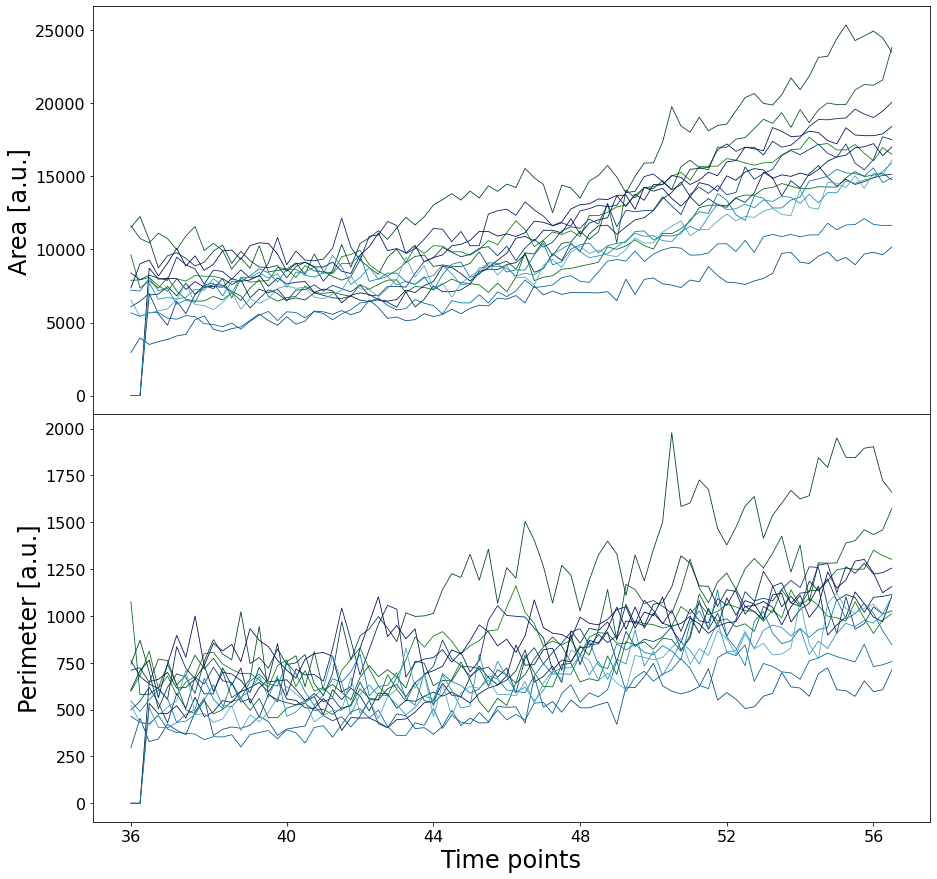

In [234]:
fig, ax = plt.subplots(2,1, figsize=(15,15))
fig.subplots_adjust(hspace=0,wspace=0)

linewidth = 0.8
mycmap = mpl.cm.get_cmap('ocean')

color_list = [mpl.colors.rgb2hex(mycmap(i)) for i in range(mycmap.N)]


for i in area_a.columns.values:
    ax[0].plot(area_a.iloc[:84,i], label=f'{i}',alpha=1,lw=linewidth)

for i in area_c.columns.values:
    ax[0].plot(area_c.iloc[:84,i], label=f'{i}',alpha=1,lw=linewidth)

ax[0].set_ylabel('Area [a.u.]')

for i in area_a.columns.values:
    ax[1].plot(perimeter_a.iloc[:84,i], label=f'{i}',alpha=1,lw=linewidth)

for i in area_c.columns.values:
    ax[1].plot(perimeter_c.iloc[:84,i], label=f'{i}',alpha=1,lw=linewidth)

ax[1].set_ylabel('Perimeter [a.u.]')
ax[1].set_xlabel("Time points")
ax[1].set_xticklabels(list([36,40,44,48,52,56]))
ax[1].set_xticks(list([0,17,33,49,65,81]))


plt.savefig('/Users/hoermann/Desktop/TLI_project/Analysis/Neurons/metrics_1.png', dpi=1000)

/var/folders/m7/96sw_tzd4rg0_kj51gyp_px8hx4v7j/T/ipykernel_69627/2577524856.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(list([36,40,44,48,52,56]))


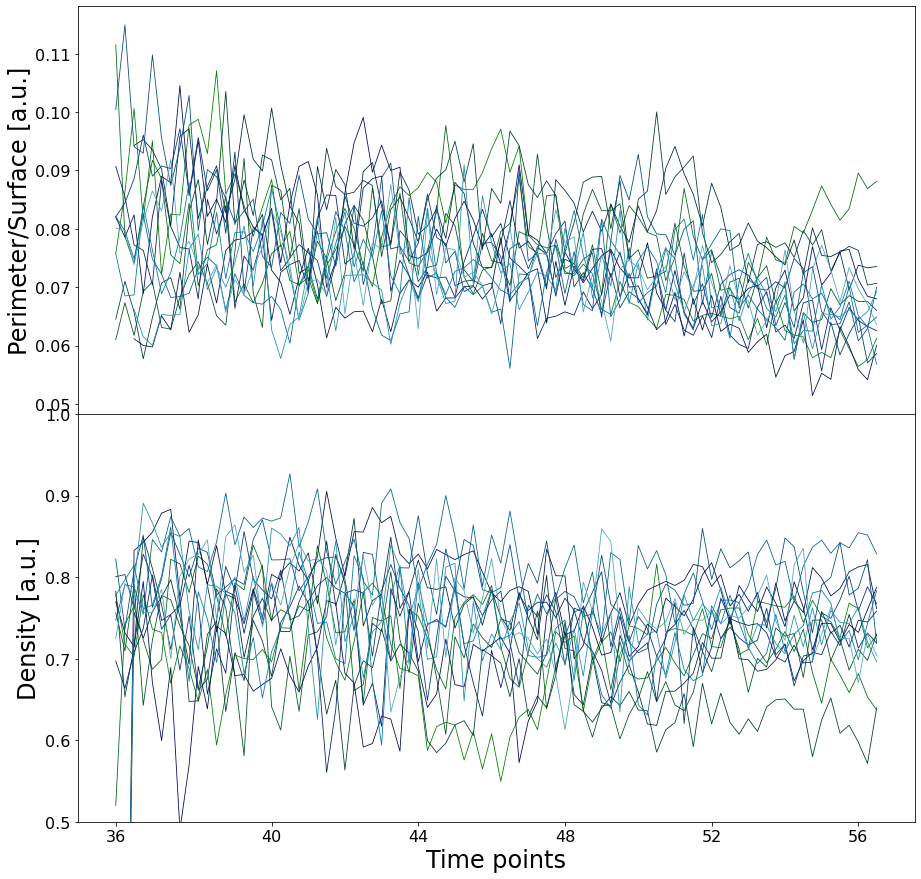

In [235]:
fig, ax = plt.subplots(2,1, figsize=(15,15))
fig.subplots_adjust(hspace=0,wspace=0)

linewidth = 0.8
mycmap = mpl.cm.get_cmap('ocean')

color_list = [mpl.colors.rgb2hex(mycmap(i)) for i in range(mycmap.N)]

for i in area_a.columns.values:
    ax[0].plot(perimeter_a.iloc[:84,i]/area_a.iloc[:84,i], label=f'{i}',alpha=1,lw=linewidth)
    

for i in area_c.columns.values:
    ax[0].plot(perimeter_c.iloc[:84,i]/area_c.iloc[:84,i], label=f'{i}',alpha=1,lw=linewidth)

ax[0].set_ylabel('Perimeter/Surface [a.u.]')

for i in area_a.columns.values:
    ax[1].plot(solidity_a.iloc[:84,i], label=f'{i}',alpha=1,lw=linewidth)

for i in area_c.columns.values:
    ax[1].plot(solidity_c.iloc[:84,i], label=f'{i}',alpha=1,lw=linewidth)

ax[1].set_ylabel('Density [a.u.]')
ax[1].set_ylim((0.5, 1))
ax[1].set_xlabel("Time points")
ax[1].set_xticklabels(list([36,40,44,48,52,56]))
ax[1].set_xticks(list([0,17,33,49,65,81]))

plt.savefig('/Users/hoermann/Desktop/TLI_project/Analysis/Neurons/metrics_2.png', dpi=1000)

In [114]:
test_regionprops = measure.regionprops(test_z_project[20])

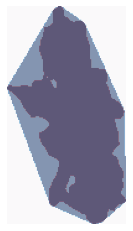

In [130]:
fig, ax = plt.subplots()

plt.imshow(test_regionprops[0].image, cmap='Reds', alpha=0.5)
plt.imshow(test_regionprops[0].image_convex, cmap='Blues', alpha=0.5)

ax.set_xticks([])
ax.set_yticks([])
ax.axis('off')

plt.savefig('/Users/hoermann/Desktop/TLI_project/Analysis/Neurons/example.png', dpi = 1000)

In [227]:
file_list_a = sorted(glob.glob('/Users/hoermann/Desktop/TLI_project/Analysis/Metrics/SubtypeA/*.csv'))

In [228]:
file_list_c = sorted(glob.glob('/Users/hoermann/Desktop/TLI_project/Analysis/Metrics/SubtypeC/*.csv'))

In [229]:
spread_dv = pd.DataFrame()
spread_ap = pd.DataFrame()
circularity = pd.DataFrame()

In [230]:
spread_dv_a = pd.DataFrame()
spread_ap_a = pd.DataFrame()
circularity_a = pd.DataFrame()

In [231]:
spread_dv_c = pd.DataFrame()
spread_ap_c = pd.DataFrame()
circularity_c = pd.DataFrame()

In [232]:
for index, file in enumerate(file_list_a):
    df = pd.read_csv(file, sep=';').iloc[:, 1:]
    spread_dv_a[index] = df['y_spread']
    spread_ap_a[index] = df['x_spread']
    circularity_a[index] = df['circularity']
    
    

In [233]:
for index, file in enumerate(file_list_c):
    df = pd.read_csv(file, sep=';').iloc[:, 1:]
    spread_dv_c[index] = df['y_spread']
    spread_ap_c[index] = df['x_spread']
    circularity_c[index] = df['circularity']

/var/folders/m7/96sw_tzd4rg0_kj51gyp_px8hx4v7j/T/ipykernel_69627/454396696.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(list([36,40,44,48,52,56]))


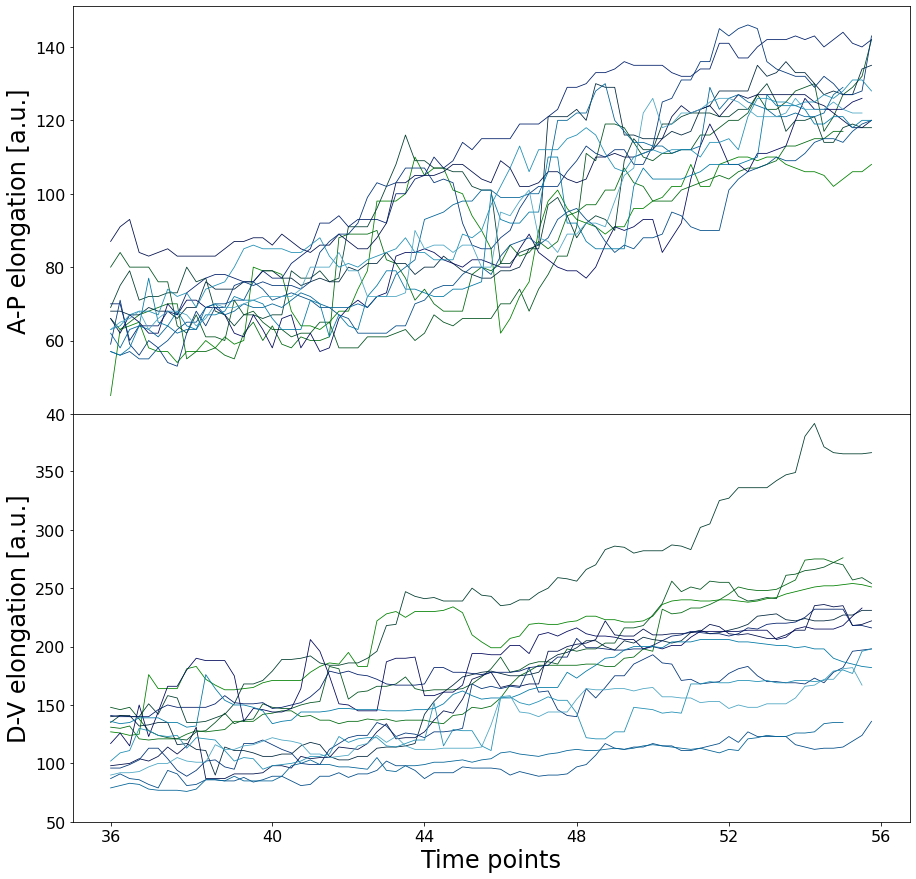

In [240]:
fig, ax = plt.subplots(2,1, figsize=(15,15))
fig.subplots_adjust(hspace=0,wspace=0)

linewidth = 0.8
mycmap = mpl.cm.get_cmap('ocean')

color_list = [mpl.colors.rgb2hex(mycmap(i)) for i in range(mycmap.N)]

for i in spread_ap_a.columns.values:
    ax[0].plot(spread_ap_a[i],alpha=1,lw=linewidth)
    
for i in spread_ap_c.columns.values:
    ax[0].plot(spread_ap_c[i],alpha=1,lw=linewidth)

ax[0].set_ylabel('A-P elongation [a.u.]')

for i in spread_dv_a.columns.values:
    ax[1].plot(spread_dv_a[i],alpha=1,lw=linewidth)

for i in spread_dv_c.columns.values:
    ax[1].plot(spread_dv_c[i],alpha=1,lw=linewidth)
    
ax[1].set_ylabel('D-V elongation [a.u.]')
ax[1].set_ylim([50,399])

ax[1].set_xlabel("Time points")
ax[1].set_xticklabels(list([36,40,44,48,52,56]))
ax[1].set_xticks(list([0,17,33,49,65,81]))

plt.savefig('/Users/hoermann/Desktop/TLI_project/Analysis/Neurons/metrics_3.png', dpi=1000)

In [221]:
circularity = pd.concat([circularity_a, circularity_c], axis=1)
spread_ap = pd.concat([spread_ap_a, spread_ap_c], axis=1)
spread_dv = pd.concat([spread_dv_a, spread_dv_c], axis=1)

In [ ]:
circularity_a.rename(columns={0:"0_a",1:"1_a",2:"2_a",3:"3_a",4:"4_a",5:"5_a",6:"6_a"}, inplace=True)
spread_ap_a.rename(columns={0:"0_a",1:"1_a",2:"2_a",3:"3_a",4:"4_a",5:"5_a",6:"6_a"}, inplace=True)
spread_dv_a.rename(columns={0:"0_a",1:"1_a",2:"2_a",3:"3_a",4:"4_a",5:"5_a",6:"6_a"}, inplace=True)

In [212]:
circularity_c.rename(columns={0:"0_c",1:"1_c",2:"2_c",3:"3_c",4:"4_c",5:"5_c",6:"6_c"}, inplace=True)
spread_ap_c.rename(columns={0:"0_c",1:"1_c",2:"2_c",3:"3_c",4:"4_c",5:"5_c",6:"6_c"}, inplace=True)
spread_dv_c.rename(columns={0:"0_c",1:"1_c",2:"2_c",3:"3_c",4:"4_c",5:"5_c",6:"6_c"}, inplace=True)

,0_a,1_a,2_a,3_a,4_a,5_a,6_a
0,0.666301,0.749534,0.793650,0.775213,0.710415,0.902107,0.795931
1,0.732607,0.748519,0.793115,0.755608,0.711734,0.877119,0.749044
2,0.736650,0.745959,0.796210,0.760322,0.726451,0.859863,0.821133
3,0.743086,0.798766,0.820049,0.744254,0.739574,0.874009,0.673944
4,0.597323,0.805168,0.800868,0.689067,0.730778,0.835785,0.787307
...,...,...,...,...,...,...,...
76,0.660684,0.637396,0.699542,0.577858,0.645953,0.749252,0.807759
77,0.661602,0.633410,0.724939,0.584286,0.651832,0.740790,0.804196
78,0.655866,NaN,0.751260,0.585359,0.654819,0.767155,0.783670
79,0.654455,NaN,0.744198,0.583114,0.652612,0.766065,0.782839


/var/folders/m7/96sw_tzd4rg0_kj51gyp_px8hx4v7j/T/ipykernel_69627/4126324882.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(list([36,40,44,48,52,56]))


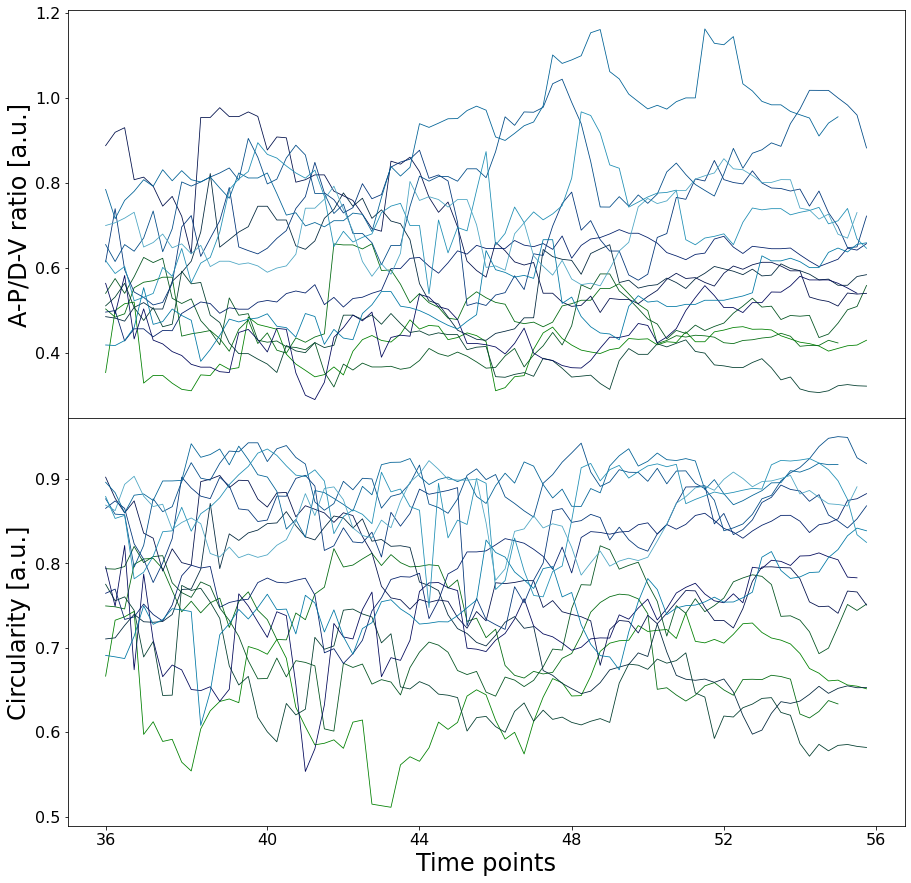

In [239]:
fig, ax = plt.subplots(2,1, figsize=(15,15))
fig.subplots_adjust(hspace=0,wspace=0)

linewidth = 0.8
mycmap = mpl.cm.get_cmap('ocean')

color_list = [mpl.colors.rgb2hex(mycmap(i)) for i in range(mycmap.N)]

for i in spread_ap_a.columns.values:
    ax[0].plot(spread_ap_a[i]/spread_dv_a[i],alpha=1,lw=linewidth)

for i in spread_ap_c.columns.values:
    ax[0].plot(spread_ap_c[i]/spread_dv_c[i],alpha=1,lw=linewidth)

ax[0].set_ylabel('A-P/D-V ratio [a.u.]')

for i in circularity_a.columns.values:
    ax[1].plot(circularity_a[i],alpha=1,lw=linewidth)
    
for i in circularity_c.columns.values:
    ax[1].plot(circularity_c[i],alpha=1,lw=linewidth)

ax[1].set_ylabel('Circularity [a.u.]')

ax[1].set_xlabel("Time points")
ax[1].set_xticklabels(list([36,40,44,48,52,56]))
ax[1].set_xticks(list([0,17,33,49,65,81]))

plt.savefig('/Users/hoermann/Desktop/TLI_project/Analysis/Neurons/metrics_4.png', dpi=1000)

In [ ]:
stable_a.shape

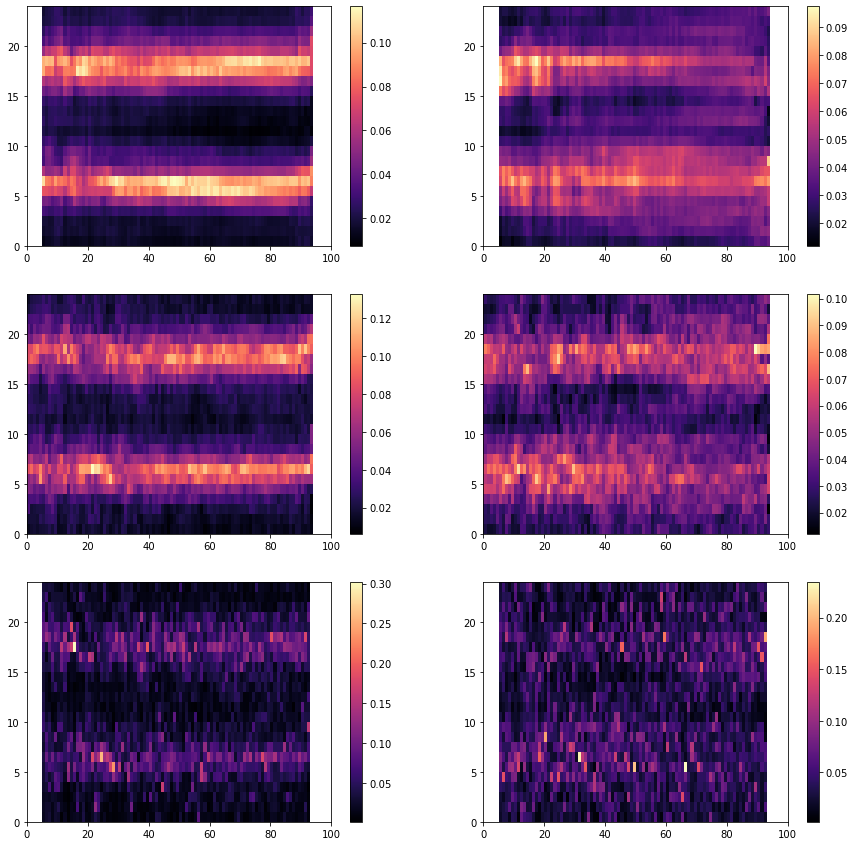

In [22]:
fig, ax = plt.subplots(3,2,figsize=(15,15))

mycmap = mpl.cm.get_cmap('magma')

pcm = np.empty((3,2),dtype=object)
pcm[0,0] = ax[0,0].pcolormesh(stable_a.T, cmap=mycmap)
pcm[0,1] = ax[0,1].pcolormesh(stable_c.T, cmap=mycmap)
pcm[1,0] = ax[1,0].pcolormesh(trans_a.T, cmap=mycmap)
pcm[1,1] = ax[1,1].pcolormesh(trans_c.T, cmap=mycmap)
pcm[2,0] = ax[2,0].pcolormesh(new_a.T, cmap=mycmap)
pcm[2,1] = ax[2,1].pcolormesh(new_c.T, cmap=mycmap)

for i in range(len(pcm)):
    for j in range(len(pcm[0])):
        fig.colorbar(pcm[i,j], ax=ax[i,j], cmap=mycmap)
        



In [86]:
test_metrics = np.zeros((100,2))

In [87]:
test.shape

(93, 86, 400, 400)

In [113]:
test_z_project = np.int8(test.sum(axis=1) > 0)

In [106]:
test_z_project.shape

(93, 400, 400)

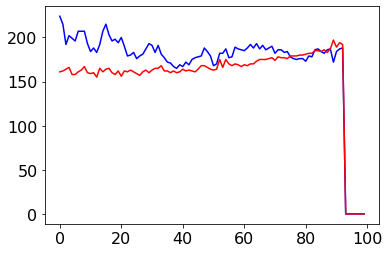

In [94]:
plt.plot(test_metrics[:,0], color='b')
plt.plot(test_metrics[:,1], color='r')

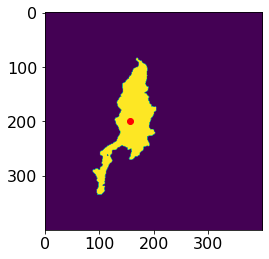

In [93]:
plt.imshow(test_z_project[20])
plt.scatter(x=test_metrics[20,1], y=test_metrics[20,0], color='r')

In [ ]:
test_coord = np.argwhere(test[20] > 0)

In [ ]:
test_coord = test_coord[:,1:]

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(15,15))
ax[0].hist(test_coord[:,1]-test_metrics[20,1], density=True)
ax[1].hist(test_coord[:,0]-test_metrics[20,0], density=True)

In [95]:
for i in range(0, test.shape[0]):
    test_metrics[i] = np.round(measure.regionprops(test_z_project[i])[0])

TypeError: loop of ufunc does not support argument 0 of type RegionProperties which has no callable rint method

In [ ]:
def calculate_z_position(path_to_data, list_of_entry_points, max_timepoints=100, bins=50):
    
    """
    This function calculates the z position of the transient and stable pixels over time.
    It takes the path to the masked files and the list of the entry points which should be in the same order.
    
    Parameters:
    path_to_data: path to the masked files
    list_of_entry_points
    
    """
    
    file_list = sorted(glob.glob(path_to_data + '*.tif'))
    
    trans_z = np.zeros((len(file_list), max_timepoints, bins))
    stable_z = np.zeros((len(file_list), max_timepoints, bins))
        
    for index, file in tqdm.tqdm(enumerate(file_list)):
        neuron_raw = tifffile.imread(file)
        neuron_raw = calculate_lifetimes(neuron_raw)
        
        neuron = neuron_raw.copy()
        neuron[(neuron < 4) * (neuron > 0)] = 1
        neuron[neuron > 3] = 2
        neuron = np.int8(neuron)

        neuron_coord_trans = np.argwhere(neuron == 1)
        neuron_coord_stable = np.argwhere(neuron == 2)

        neuron_coord_trans[:,1:] = neuron_coord_trans[:,1:] - list_of_entry_points[index]
        neuron_coord_stable[:,1:] = neuron_coord_stable[:,1:] - list_of_entry_points[index]
        
        for i in range(0,neuron.shape[0]):
            z_pos = np.histogram(neuron_coord_trans[neuron_coord_trans[:,0] == i][:,1],
                                  bins=np.array(range(int(-bins/2),int(bins/2 + 1),1))
                                 )
            trans_z[index, i] = z_pos[0]


        for i in range(3,neuron.shape[0]):
            z_pos = np.histogram(neuron_coord_stable[neuron_coord_stable[:,0] == i][:,1],
                                  bins=np.array(range(int(-bins/2),int(bins/2 + 1),1))
                                 )
            stable_z[index, i] = z_pos[0]
        
    stable_z[stable_z==0] = np.NaN
    trans_z[trans_z==0] = np.NaN

    df_stable_z = pd.DataFrame(np.nanmean(stable_z, axis=0))
    df_stable_z_std = pd.DataFrame(np.nanstd(stable_z, axis=0))

    df_trans_z = pd.DataFrame(np.nanmean(trans_z, axis=0))
    df_trans_z_std = pd.DataFrame(np.nanstd(trans_z, axis=0))
    
    stable_sum = df_stable_z.sum(axis=1)
    stable_std_sum = df_stable_z_std.sum(axis=1)
    trans_sum = df_trans_z.sum(axis=1)
    trans_std_sum = df_trans_z_std.sum(axis=1)
    
    for i in range(0, bins):
        df_stable_z.iloc[:,i] = df_stable_z.iloc[:,i]/stable_sum
        df_stable_z_std.iloc[:,i] = df_stable_z_std.iloc[:,i]/stable_std_sum
        df_trans_z.iloc[:,i] = df_trans_z.iloc[:,i]/trans_sum
        df_trans_z_std.iloc[:,i] = df_trans_z_std.iloc[:,i]/trans_std_sum

    return df_stable_z, df_stable_z_std, df_trans_z, df_trans_z_std

In [ ]:
df_stable_z, df_stable_z_std, df_trans_z, df_trans_z_std = calculate_z_position(path_to_data, entry_points)

In [ ]:
df_stable_z_cd, df_stable_z_std_cd, df_trans_z_cd, df_trans_z_std_cd = calculate_z_position(path_to_data_cd, entry_points_cd)

In [ ]:
fig, ax = plt.subplots(2,2,figsize=(15,15))

pcm = np.empty((2,2),dtype=object)
pcm[0,0] = ax[0,0].pcolormesh(df_stable_z[3:88].T)
pcm[0,1] = ax[0,1].pcolormesh(df_stable_z_cd[3:88].T)
pcm[1,0] = ax[1,0].pcolormesh(df_trans_z[:88].T)
pcm[1,1] = ax[1,1].pcolormesh(df_trans_z_cd[:88].T)

for i in range(len(pcm)):
    for j in range(len(pcm[0])):
        fig.colorbar(pcm[i,j], ax=ax[i,j])

In [ ]:
def check_lifetimes(path_to_data, max_timepoints=100, lifetime=8):
    """
    This function calculates the lifetimes of pixels of every neuron and takes the mean values of 
    transient, stable and total pixels over all timepoints.
    
    
    Parameters:
    path_to_data: Path to the masks
    max_timepoints: Maximum timepoints in all of the datasets
    lifetime: minimum timepoints for a pixel to be consecutively alive to be called stable
    
    Returns:
    df_values: Dataframe containing the mean values for the transient, stable and total pixels
    df_std: Dataframe containing the std of the transient, stable and total pixels
    """
    
    file_list = sorted(glob.glob(path_to_data + '*.tif'))
    
    values = np.zeros((3,7,max_timepoints))
    
    for index,file in tqdm.tqdm(enumerate(file_list)):
        neuron = tifffile.imread(file)
        
        neuron = calculate_lifetimes(neuron)
        neuron[(neuron < lifetime) * (neuron > 0)] = 1
        neuron[neuron > lifetime-1] = 2
        neuron = np.int8(neuron)
        
        transient = np.int8(neuron == 1).sum(axis=(1,2,3))
        stable = np.int8(neuron ==2).sum(axis=(1,2,3))
        all_pixels = transient + stable
        
        values[0,index, :len(transient)] = transient
        values[1,index, :len(stable)] = stable
        values[2,index, :len(all_pixels)] = all_pixels
        
    values_std = np.std(values, axis=1)
    values = np.mean(values, axis=1)
    
    values = pd.DataFrame(values)
    values_std = pd.DataFrame(values_std)
    
    return values, values_std  

In [ ]:
diff_lifetimes = {}

for i in tqdm.tqdm(range(2,16,1)):
    values, values_std = check_lifetimes(path_to_data_a, lifetime=i)
    diff_lifetimes[i] = (values, values_std)

In [ ]:
f = open("/Users/hoermann/Desktop/TLI_project/Analysis/Neurons/check_lifetimes_a.pkl","wrb")

# write the python object (dict) to pickle file
pickle.dump(diff_lifetimes,f)

# close file
f.close()

In [ ]:
filename = '/Users/hoermann/Desktop/TLI_project/Analysis/Neurons/check_lifetimes_a.pkl'

with open(filename, 'rb') as handle:
    b = pickle.load(handle)
b[2][0]

In [112]:
test = tifffile.imread('/Users/hoermann/Desktop/TLI_project/Analysis/Neurons/SubtypeA/masks/211104_P36_N2_R270_mask.tif')

In [ ]:
filename = '/Users/hoermann/Desktop/TLI_project/Analysis/Neurons/test.pkl'
with open(filename, 'wb') as handle:
    pickle.dump(test,handle)



In [ ]:
filename = '/Users/hoermann/Desktop/TLI_project/Analysis/Neurons/lifetimes_all.pkl'

with open(filename, 'rb') as handle:
    diff_lifetimes = pickle.load(handle)


In [ ]:
df_stable_lifetimes = pd.DataFrame()
df_transient_lifetimes = pd.DataFrame()
df_all_lifetimes = pd.DataFrame()

In [ ]:
for i in range(2,16):
    df_stable_lifetimes[i] = diff_lifetimes[i][0].iloc[:,1]
    df_transient_lifetimes[i] = diff_lifetimes[i][0].iloc[:,0]
    df_all_lifetimes[i] = diff_lifetimes[i][0].iloc[:,2]

In [ ]:
df_stable_lifetimes_std = pd.DataFrame()
df_transient_lifetimes_std = pd.DataFrame()
df_all_lifetimes_std = pd.DataFrame()

In [ ]:
for i in range(2,16):
    df_stable_lifetimes_std[i] = diff_lifetimes[i][1].iloc[:,1]
    df_transient_lifetimes_std[i] = diff_lifetimes[i][1].iloc[:,0]
    df_all_lifetimes_std[i] = diff_lifetimes[i][1].iloc[:,2]

In [ ]:
fig, ax = plt.subplots(5,1, figsize=(15,20), sharex=True)
fig.subplots_adjust(hspace=0,wspace=0)

for i in range(2,16):
    ax[0].plot(df_stable_lifetimes[i], label=f'{i}', lw=0.8)
    ax[1].plot(df_transient_lifetimes[i], lw=0.8)
    ax[2].plot(df_transient_lifetimes[i]/df_stable_lifetimes[i], lw=0.8)
    ax[3].plot(df_stable_lifetimes[i]/df_all_lifetimes[i], lw=0.8)
    ax[4].plot(df_transient_lifetimes[i]/df_all_lifetimes[i], lw=0.8)

    
ax[0].set_ylabel('# stable pixels')
ax[1].set_ylabel('# transient pixels')
ax[2].set_ylabel('Ratio transient to Stable')
ax[3].set_ylabel('Ratio stable to all pixels')
ax[4].set_ylabel('Ratio transient to all pixels')
ax[4].set_xlabel('Time points')

ax[0].legend(bbox_to_anchor=(1,1), loc="upper left")
plt.savefig('/Users/hoermann/Desktop/TLI_lifetimes.png', dpi=1000)

In [ ]:
fig, ax = plt.subplots(5,1, figsize=(15,20), sharex=True)
fig.subplots_adjust(hspace=0,wspace=0)

for i in range(2,16):
    ax[0].plot(df_stable_lifetimes_std[i], label=f'{i}', lw=0.8)
    ax[1].plot(df_transient_lifetimes_std[i], lw=0.8)
    ax[2].plot(df_all_lifetimes_std[i], lw=0.8)
    ax[3].plot(df_stable_lifetimes_std[i]/df_stable_lifetimes[i], lw=0.8)
    ax[4].plot(df_transient_lifetimes_std[i]/df_transient_lifetimes[i], lw=0.8)
    
    
ax[0].set_ylabel('Std stable pixels')
ax[1].set_ylabel('Std transient pixels')
ax[2].set_ylabel('Std all pixels')
ax[3].set_ylabel('Ratio std/pixels stable')
ax[4].set_ylabel('Ratio std/pixels transient')
ax[4].set_xlabel('Time points')

ax[0].legend(bbox_to_anchor=(1,1), loc="upper left")
plt.savefig('/Users/hoermann/Desktop/TLI_project/Analysis/Neurons/lifetimes_std.png', dpi=1000)

In [ ]:
test_coord_stable = np.argwhere(test_life == 2)

In [ ]:
test_coord_stable[:,1:] = test_coord_stable[:,1:] - [42,225,175]

In [ ]:
test_coord_stable

In [ ]:
test_angle = np.rad2deg(np.arctan2(test_coord_stable[:,2], test_coord_stable[:,3]))

In [ ]:
test_hist = np.histogram(test_angle,
                                  bins=np.array(range(-180,180 + int(360/24),int(360/24)))
                                 )

In [ ]:
test_hist

In [ ]:
test_z_dist = pd.DataFrame()
test_z_dist['slice'] = list(range(0,37,1))
test_z_dist = test_z_dist.set_index('slice')

In [ ]:
for i in tqdm.tqdm(range(0,test.shape[0])):
    z_dist = np.histogram(test_short[test_short[:,0]==i,1], bins=list(range(0,39,1)), density=True)
    test_z_dist[i] = z_dist[0]

In [ ]:
test_z_dist

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))

ax.pcolormesh(test_z_dist)
ax.invert_yaxis()
fig.colorbar(ax.pcolormesh(test_z_dist, cmap='coolwarm'))

In [ ]:
test_short_z_dist = test_short

In [ ]:
test_short_z_dist[:,1:4] = test_short[:,1:4] - entry_point_211107_N2

In [ ]:
test_short_z_dist = np.column_stack((test_short_z_dist,np.linalg.norm(test_short_z_dist[:,2:4], axis=1)))

In [ ]:
fig, ax = plt.subplots()
ax.scatter(test_short_z_dist[:,4], test_short_z_dist[:,1])
ax.invert_yaxis()

In [ ]:
test_z_dist_time = pd.DataFrame()
test_z_dist_time['distance'] = list(range(0,100,1))
test_z_dist_time = test_z_dist_time.set_index('distance')

In [ ]:
for i in tqdm.tqdm(range(0,test.shape[0])):
    dist = np.histogram(test_short_z_dist[test_short_z_dist[:,0]==i,4], bins=list(range(0,101,1)), density=True)
    test_z_dist_time[i] = dist[0]

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))

ax.pcolormesh(test_z_dist_time)
ax.invert_yaxis()
fig.colorbar(ax.pcolormesh(test_z_dist_time, cmap='coolwarm'))

In [ ]:
def last_life_dist_angle(path_to_data, entry_points, lifetime=6):
    """
    This function calculates the pixel lifetimes and then takes the last stack to calculate the distance to the 
    entry point, angle and lifetime of the pixels.
    
    Parameters:
    path_to_data: Path to the folder containing the data. Multiple paths are fine
    """
    
    
    file_list = []
    for path in path_to_data:
        file_list.append(sorted(glob.glob(path + '*.tif')))
    file_list = list(itertools.chain(*file_list))
    
    
    

In [ ]:
path_to_data = ['/Users/hoermann/Desktop/TLI_project/Analysis/Neurons/SubtypeA/masks/', 
               'aklsdjkladsk']

In [ ]:
file_list = []

for path in path_to_data:
    file_list.append(sorted(glob.glob(path + '*.tif')))
file_list = list(itertools.chain(*file_list))

In [ ]:
path_to_data.count(path_to_data)